# The effect of COVID-19 on deliveredKwh
We designed a machine learning-based model (an LSTM-based) that uses the value of "Temp", "isWeekened", and "dailyDelivered" of past records to predict the current value of "dailyDeleivered". 

We monitored the prediction error of the pre and post COVID data to observe the effect of COVID-19 on the prediction error. 
We also observed the sign of the prediction error to see whether the predicted dailyDelivered values are greater or less than the actula values.
The following code and results are for a dataset that contains data of residential premises.

As this model uses the immediate past values of "dailyDelivered" in its prediction, it works closely well for both pre-covid and post-covid data. The prediction error for post-covid data is greater than the one for pre-covid data.

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from matplotlib.pyplot import locator_params
from numpy import genfromtxt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from operator import add
import tensorflow as tf
#rom keras.backend import tensorflow_backend as K
import statsmodels
import statistics
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
def temporalize(arr,win_size,step_size,features,add_index=0):
  """
  arr: any 2D array whose columns are distinct variables and 
    rows are data records at some timestamp t
  win_size: size of data window (given in data points)
  step_size: size of window step (given in data point)
  
  Note that step_size is related to window overlap (overlap = win_size - step_size), in 
  case you think in overlaps."""
  #
  dataFrameTimeseries=pd.DataFrame()
  #
  w_list = list()
  n_records = arr.shape[0]
  remainder = (n_records - win_size) % step_size 
  num_windows = 1 + int((n_records - win_size - remainder) / step_size)
  for k in range(num_windows):
    w_list.append(arr[k*step_size:win_size-1+k*step_size+1])
    #
    #convert the matrix to data frame
    dataFrameTemp=pd.DataFrame(data=arr[k*step_size:win_size-1+k*step_size+1], columns=features)
    dataFrameTemp["timeseriesId"]=k+add_index
    dataFrameTimeseries=pd.concat([dataFrameTimeseries,dataFrameTemp])
    #
  return np.array(w_list),dataFrameTimeseries


In [3]:
def is_number(s):
        try:
            float(s)
            return True
        except ValueError:
            pass
        
        try:
            import unicodedata
            unicodedata.numeric(s)
            return True
        except (TypeError, ValueError):
            pass
        return False 

In [4]:
def plot_(h_axis,v1_axis,v2_axis):
    plt.rcParams.update({'font.size': 15})
    plt.tight_layout()
    plt.figure(figsize=(30,3))
    plt.plot(h_axis, v1_axis, color="blue",marker="o", label="actual")
    plt.plot(h_axis,v2_axis, color="red",marker="o",label="predicted")
    plt.xticks(h_axis[0::31],rotation=90)
    plt.title("Residential Daily Delivered (kWh)")
    plt.show()

In [5]:
# split into train and test sets
def split_(dataset, train_size=0.67, dimension=2):
    train_size = int(len(dataset) * train_size)
    test_size = len(dataset) - train_size
    train=[]
    test=[]
    if dimension==1:
        train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
    else:
        train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    return train,test

In [6]:
win_size=10
overlap=win_size-1

In [7]:
dataset = pd.read_csv('datasets/pow_temp_isweekday.csv', engine='python')
#preprocess data
dataset=dataset.fillna(-1)
for column in dataset.columns:
    if is_number(dataset.iloc[1][column]) and column!="id":
        min_max=MinMaxScaler(feature_range=(0, 1))
        dataset[[column]]=min_max.fit_transform(dataset[[column]])

n_features=len(dataset.columns.values)
X,dataFrameTimeseries=temporalize(dataset.to_numpy(),win_size,win_size-overlap,dataset.columns.values)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1920      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 20)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 20)            3280      
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 3)             63        
Total params: 5,263
Trainable params: 5,263
Non-trainable params: 0
_________________________________________________________________
prediction error on pre-covid data
**********************************
[0.00204264]
prediction error on post-covid data
**********************************
[0.00493585]
Error sign (actual-prediction) for post covid data: If Positive--> actual is greater 

<Figure size 432x288 with 0 Axes>

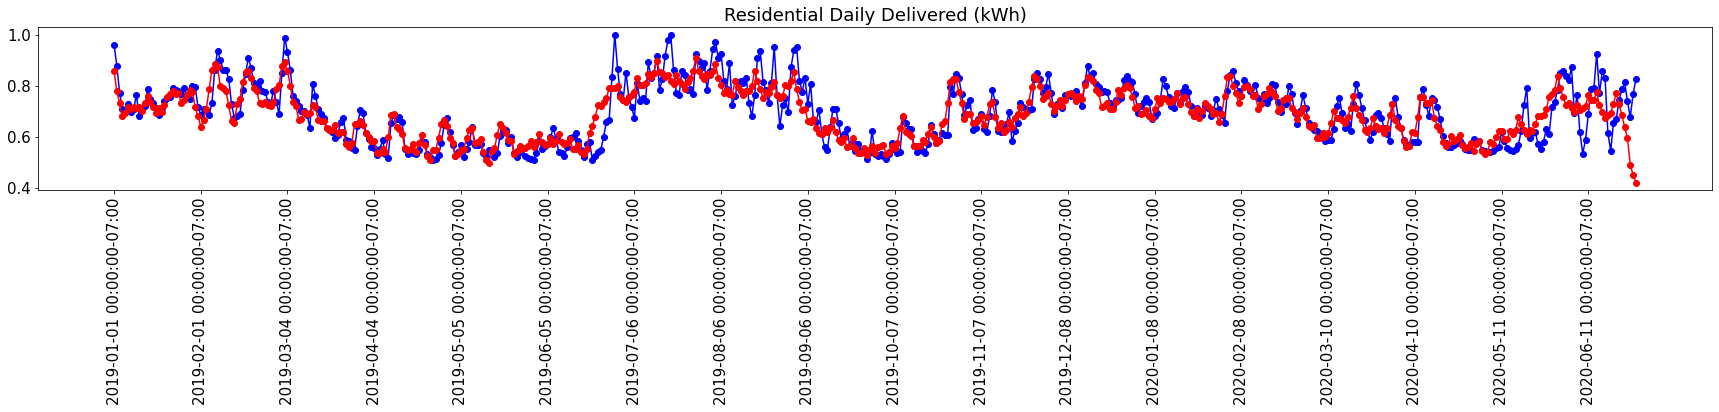

In [8]:
#LSTM-Autoencoder
model = Sequential()
model.add(LSTM(20,activation='tanh', input_shape=(win_size,n_features-2), return_sequences=False))
#model.add(LSTM(3, activation='relu', return_sequences=False))
model.add(RepeatVector(win_size))
#model.add(LSTM(3, activation='relu', return_sequences=True))
model.add(LSTM(20, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(n_features-2)))
model.compile(optimizer='adam', loss="mse")
model.summary()

#remove id and time for trainig
X_preprocessed=np.asarray(np.delete(X,[0,1],axis=2)).astype(np.float32)
#train on precovid data (76% of data) and test on all dataset
train,test=split_(X_preprocessed,0.76)

model.fit(train, train, epochs=500, verbose=0)
#prediction error on pre-covid data (training data)
yhat1 = model.predict(train, verbose=0)
prediction_error1=np.square(train-yhat1).mean(axis=None).ravel()
print("prediction error on pre-covid data")
print("**********************************")
print(prediction_error1)

#prediction error on post-covid data (testing data)
yhat2 = model.predict(test, verbose=0)
prediction_error2=np.square(test-yhat2).mean(axis=None).ravel()
print("prediction error on post-covid data")
print("**********************************")
print(prediction_error2)

print("Error sign (actual-prediction) for post covid data: If Positive--> actual is greater than predicted")
print("**********************************")
print((test-yhat2).mean(axis=None))

#predict the entire data
yhat = model.predict(X_preprocessed, verbose=1)
#this structure is because overlap is win_size-1. Uncomment the commented lines for overlap=0
#h_axis=np.array(dataFrameTimeseries["time"])
h_axis=np.array(X)[:,0,1].flatten()
#v1_axis=np.array(dataFrameTimeseries["residential-dailyDelivered"])
v1_axis=np.array(X)[:,0,3].flatten()
#v2_axis=np.array(yhat)[:,:,1].flatten()
v2_axis=np.array(yhat)[:,0,1].flatten()
plot_(h_axis,v1_axis,v2_axis)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 41,701
Trainable params: 41,701
Non-trainable params: 0
_________________________________________________________________
prediction error on pre-covid data
**********************************
[0.02160737]
prediction error on post-covid data
**********************************
[0.03631474]
Error sign (actual-prediction) for post covid data: If Positive--> actual is greater than predicted
**********************************
-0.012163313


<Figure size 432x288 with 0 Axes>

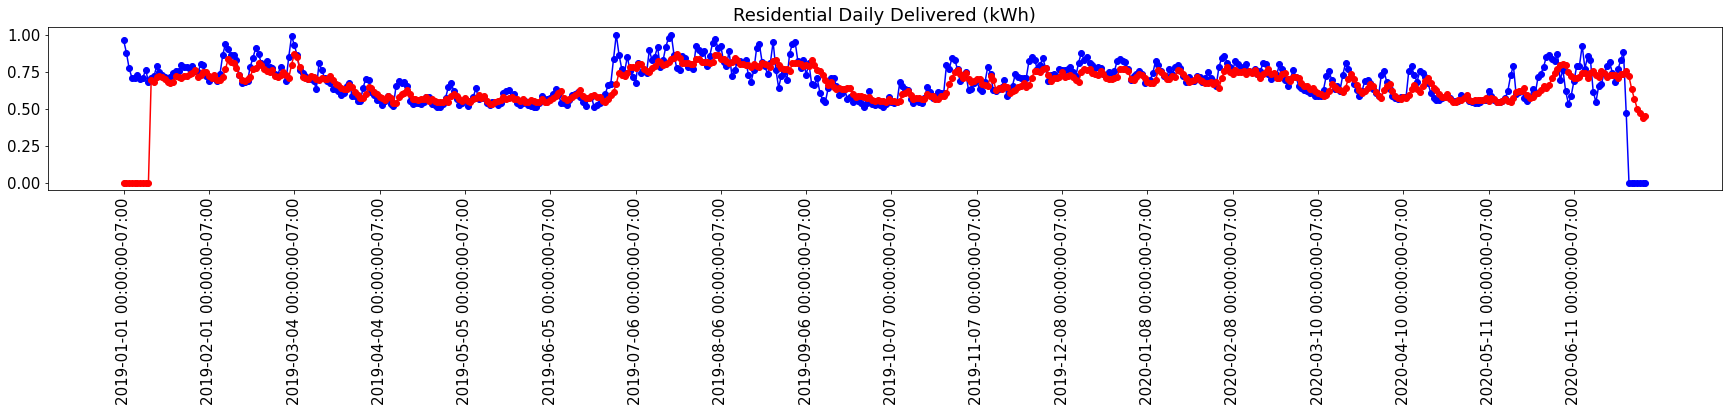

In [9]:
#Original LSTM
X=X[0:-1,:]
#only use delivered as network output. Shift Y by window size
Y=dataset.to_numpy()[win_size:,3].astype(np.float32)

model = Sequential()
model.add(LSTM(100, activation=('tanh'), dropout=0.2, recurrent_dropout=0.2, stateful = False, input_shape = (win_size,n_features-2)))
model.add(Dense(1))
model.compile(loss=keras.losses.mean_squared_error, optimizer='rmsprop')
model.summary()

#remove id and time for trainig
X_preprocessed=np.asarray(np.delete(X,[0,1],axis=2)).astype(np.float32)
#train on precovid data (76% of data) and test on all dataset
p=0.76
Xtrain,Xtest=split_(X_preprocessed,p)
Ytrain,Ytest=split_(Y,p,1)

model.fit(Xtrain, Ytrain,epochs=500,verbose=0)
#prediction error on pre-covid data (training data)
yhat1 = model.predict(Xtrain, verbose=0)
prediction_error1=np.square(Ytrain-yhat1).mean(axis=None).ravel()
print("prediction error on pre-covid data")
print("**********************************")
print(prediction_error1)

#prediction error on post-covid data (testing data)
yhat2 = model.predict(Xtest, verbose=0)
prediction_error2=np.square(Ytest-yhat2).mean(axis=None).ravel()
print("prediction error on post-covid data")
print("**********************************")
print(prediction_error2)

print("Error sign (actual-prediction) for post covid data: If Positive--> actual is greater than predicted")
print("**********************************")
print((Ytest-yhat2).mean(axis=None))

#predict the entire data
yhat=model.predict(X_preprocessed)

h_axis=dataset["time"]
v1_axis=dataset["residential-dailyDelivered"]
v2_axis=yhat.flatten()
temp=np.zeros(win_size)
v2_axis=np.concatenate([temp,v2_axis])
plot_(h_axis,v1_axis,v2_axis)